# Проект №3: Exploratory Data Analysis and Feature Engineering #

**Подробное описание постановки задачи, ссылки на Kaggle (Competition + Notebook) приведены в файле [README.md](README.md)**

In [388]:
import pandas as pd

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from scipy import stats
import category_encoders as ce

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

DATA_PATH = 'data/'
# DATA_PATH = '/kaggle/input/sf-booking/'
OUTPUT_PATH = 'output/'
# OUTPUT_PATH = ''
RANDOM_STATE = 42

## Сбор и предварительный анализ данных (Data Collection) ##

In [389]:
train_ini = pd.read_csv(DATA_PATH + 'hotels_train.csv')
test_ini = pd.read_csv(DATA_PATH + 'hotels_test.csv')
submission_df = pd.read_csv(DATA_PATH + 'submission.csv')

In [508]:
# Далее временно удобно работать с копиями датасетов
train_df = train_ini.copy()
test_df = test_ini.copy()

In [504]:
train_df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [505]:
test_df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [392]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [393]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [509]:
test_df['reviewer_score'] = pd.NA
train_df['is_train'] = True
test_df['is_train'] = False
full_df = pd.concat([train_df, test_df], axis='index', ignore_index=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [455]:
# Проверка на одновременное отстутствие 'lat' и 'lng' в одной строке
for df_ in train_df, test_df:
    print(df_.isna().sum(axis='columns').value_counts())

0    384355
2      2448
dtype: int64
0    128115
2       820
dtype: int64


Видно, что в обоих датасетах есть незаполненные координаты широты и долготы. Причём они отсутствуют одновременно, то есть нет строк с одной заполненной координатой, что немного упрощает дальнейшую работу.

Можно сразу преобразовать **`review_date`** в формат **`datetime`** и посмотреть, в какой период собирались данные.

In [456]:
for df_ in train_df, test_df:
    df_.review_date = pd.to_datetime(df_.review_date)

print(f'TRAIN_DF: данные с {train_df.review_date.min()} по {train_df.review_date.max()}')
print(f'TEST_DF: данные с {test_df.review_date.min()} по {test_df.review_date.max()}')

TRAIN_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00
TEST_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00


В обоих датасетах данные собраны с 4 августа 2015 по 4 августа 2017.

## Стратегия дальнейшей работы ##

Так как в данном проекте метод обучения модели фиксирован (RandomForestRegressor), и задан критерий качества модели&nbsp;&mdash; достижение минимального значения MAPE (Mean Absolute Percentage Error), то вместо последовательных этапов работы с данными (очистка, создание, преобразование, отбор) представляется более интересной следующая стратегия:

Первой итерацией будет простой отбор всех имеющихся числовых признаков и получение первого значения MAPE, от которого потом можно &laquo;плясать&raquo; далее по такому циклу:

1. Берём признак и смотрим, что можно сделать с числовым признаком (непрерывный/категориальный, распределение нормальное/нет, необходимость нормализации, стандартизации и других преобразований)
2. То же и с строковым признаком (что можно вытянуть из строк сначала в числа или категории, далее &laquo;GOTO пункт 1&raquo;).
3. Отбор признаков (устранение излишней корреляции и мультиколлинеарности).
4. Обучение модели, отслеживание MAPE и анализ важности признаков.

Может быть получится излишне трудоёмко, но главная цель представляется как проработка процесса подготовки данных для готовой модели.

### 1. **`hotel_address`**, **`lat`**, **`lng`**: One-hot-кодирование признаков города из **`hotel_address`** и заполнение недостающих **`lat`** и **`lng`** среднегородскими значениями ###

In [457]:
# Создание временного логического признака 'lost_hotel'
# (где координаты отсутствуют)
for df_ in train_df, test_df:
    df_['lost_hotel'] = df_.lat.isna()

print(f'TRAIN_DF: {train_df.hotel_address.nunique()} уникальных адресов отелей')
print(f'TEST_DF: {test_df.hotel_address.nunique()} уникальных адресов отелей\n')

print(f'TRAIN_DF: {train_df.lng.nunique()} уникальных долгот')
print(f'TEST_DF: {test_df.lng.nunique()} уникальных долгот\n')

print(f'TRAIN_DF: {train_df.lat.nunique()} уникальных широт')
print(f'TEST_DF: {test_df.lat.nunique()} уникальных широт\n')

print(f'TRAIN_DF: {train_df[train_df.lost_hotel].hotel_address.nunique()} отелей без координат')
print(f'TEST_DF: {test_df[test_df.lost_hotel].hotel_address.nunique()} отелей без координат')

TRAIN_DF: 1493 уникальных адресов отелей
TEST_DF: 1493 уникальных адресов отелей

TRAIN_DF: 1472 уникальных долгот
TEST_DF: 1472 уникальных долгот

TRAIN_DF: 1472 уникальных широт
TEST_DF: 1472 уникальных широт

TRAIN_DF: 17 отелей без координат
TEST_DF: 17 отелей без координат


Итак, мы имеем дело всего с **1493** отелями. Для них есть **1473** уникальных координат и всего **17** отелей без координат (далее&nbsp;&mdash; &laquo;потерянные отели&raquo;, `lost_hotel` для удобства). Видимо, ещё у **3** оставшихся отелей координаты могут совпадать с какими-то другими.

Ещё можно посмотреть структуру содержимого **`hotel_address`**:

In [458]:
for str_ in train_df.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Структура ясна, можно посчитать число стран и городов, встречающихся во всех адресах:

In [459]:
countries = set()
cities = set()
for str_ in train_df.hotel_address:
    addr_ = str_.split()
    countries.add(addr_[-1])
    if addr_[-1] == 'Kingdom':
        cities.add(addr_[-5])
    else:
        cities.add(addr_[-2])
print(f'Всего {len(countries)} стран: {countries}')
print(f'Всего {len(cities)} городов: {cities}')

Всего 6 стран: {'Netherlands', 'Spain', 'Italy', 'Austria', 'France', 'Kingdom'}
Всего 6 городов: {'Vienna', 'London', 'Amsterdam', 'Milan', 'Barcelona', 'Paris'}


Выяснилось, что в обучающем и тестовом датасетах содержатся отели только из шести городов однозначно соответствующих шести стран. Тогда в обоих датасетах можно сделать следующее:

Извлекаем название город из **`hotel_address`** во временный признак **`city`**

In [460]:
def get_city(addr_str: str) -> str:
    ''' Находит в строке адреса название города
    Arguments:
        addr_str [str] -- Содержимое ячейки признака 'hotel_address'
    Returns:
        [str] -- Название города
    '''
    words_list = addr_str.split()
    if words_list[-1] == 'Kingdom':
        return words_list[-5]
    else:
        return words_list[-2]
    return 'Unknown'

# Создание временного признака 'city' для города
for df_ in train_df, test_df:
    df_['city'] = df_.hotel_address.apply(get_city)

Интересно узнать количество потерянных отелей по городам в обучающем датасете (в тестовом то же самое, проверено):

In [461]:
# Выделение строк с потерянными отелями в отдельные датафреймы
train_lost_hotel_df = train_df[train_df.lost_hotel]
test_lost_hotel_df = test_df[test_df.lost_hotel]

city_list = train_lost_hotel_df.city.unique()
for city_ in city_list:
    print(
        city_ + ':',
        train_lost_hotel_df[train_lost_hotel_df.city == city_].hotel_address.nunique(),
        'потерянных отелей'
    )

Vienna: 11 потерянных отелей
Paris: 3 потерянных отелей
Barcelona: 3 потерянных отелей


У нас не так уж много потерянных отелей. Можно даже заполнить их **`lat`** и **`lng`** вручную истинными координатами, определёнными по адресам, но можно поступить проще. Поскольку пара значений `(lat, lng)` представляют своего рода уникальный идентификатор, то достаточно каждому адресу отеля сопоставить такую уникальную числовую пару. Почти &laquo;от фонаря&raquo;. Например, чтобы не сильно портить статисткику распределения, для 17 отелей назначить пары в пределах IQR (от Q25 до Q75) для каждого из трёх городов.

In [401]:
'''
# Составление словаря адресов потерянных отелей (key)
# с новыми координатами (value)
lost_hotel_coords_dict = {}
for city_ in ['Vienna', 'Paris', 'Barcelona']:
    # Выборки для конкретного города
    df = train_df[train_df.city == city_]
    lost_hotel_df = train_lost_hotel_df[train_lost_hotel_df.city == city_]
    # Список адресов потерянных отелей в городе
    lost_hotel_addr_list = list(lost_hotel_df.hotel_address.unique())
    lost_hotel_count = len(lost_hotel_addr_list)
    # Определение границ IQR для 'lat' и 'lng'
    lat_q25 = df.lat.quantile(0.25)
    lat_q75 = df.lat.quantile(0.75)
    lng_q25 = df.lng.quantile(0.25)
    lng_q75 = df.lng.quantile(0.75)
    # Формирование наборов значений для 'lat' и 'lng'
    lat_tuple = tuple(np.linspace(lat_q25, lat_q75, lost_hotel_count))
    lng_tuple = tuple(np.linspace(lng_q25, lng_q75, lost_hotel_count))
    # Формирование словаря
    coords_dict = dict(zip(lost_hotel_addr_list, zip(lat_tuple, lng_tuple)))
    lost_hotel_coords_dict.update(coords_dict)

# Составление списков индексов строк с потерянными отелями
train_lost_hotel_index_list = list(train_lost_hotel_df.index)
test_lost_hotel_index_list = list(test_lost_hotel_df.index)

# Заполнение отсутствующих координат в обучающем датасете
for i_ in train_lost_hotel_index_list:
    new_coords = lost_hotel_coords_dict.get(train_df.hotel_address.iloc[i_])
    train_df.lat.iloc[i_] = new_coords[0]
    train_df.lng.iloc[i_] = new_coords[1]

# Заполнение отсутствующих координат в тестовом датасете
for i_ in test_lost_hotel_index_list:
    new_coords = lost_hotel_coords_dict.get(test_df.hotel_address.iloc[i_])
    test_df.lat.iloc[i_] = new_coords[0]
    test_df.lng.iloc[i_] = new_coords[1]

display(train_df.info())
display(test_df.info())
'''

"\n# Составление словаря адресов потерянных отелей (key)\n# с новыми координатами (value)\nlost_hotel_coords_dict = {}\nfor city_ in ['Vienna', 'Paris', 'Barcelona']:\n    # Выборки для конкретного города\n    df = train_df[train_df.city == city_]\n    lost_hotel_df = train_lost_hotel_df[train_lost_hotel_df.city == city_]\n    # Список адресов потерянных отелей в городе\n    lost_hotel_addr_list = list(lost_hotel_df.hotel_address.unique())\n    lost_hotel_count = len(lost_hotel_addr_list)\n    # Определение границ IQR для 'lat' и 'lng'\n    lat_q25 = df.lat.quantile(0.25)\n    lat_q75 = df.lat.quantile(0.75)\n    lng_q25 = df.lng.quantile(0.25)\n    lng_q75 = df.lng.quantile(0.75)\n    # Формирование наборов значений для 'lat' и 'lng'\n    lat_tuple = tuple(np.linspace(lat_q25, lat_q75, lost_hotel_count))\n    lng_tuple = tuple(np.linspace(lng_q25, lng_q75, lost_hotel_count))\n    # Формирование словаря\n    coords_dict = dict(zip(lost_hotel_addr_list, zip(lat_tuple, lng_tuple)))\n    

Заполняем пустые ячейки в признаках **`lat`** и **`lng`** координатами центров соответствующих городов (взяты из внешних источников)

In [462]:
for df_ in train_df, test_df:
    df_.lat.fillna(0, inplace=True)
    df_.lng.fillna(0, inplace=True)

''' Координаты центров городов (lat, lng) из внешних источников '''
CITY_COORDS = {
    'Amsterdam': (52.383333, 4.9),
    'Barcelona': (41.383333, 2.183333),
    'London': (51.507222, -0.1275),
    'Milan': (45.466667, 9.166667),
    'Paris': (48.833333, 2.333333),
    'Vienna': (48.216667, 16.373333)
}

def write_lat(city_: str, lat_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение широты в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        lat_ [float] -- Широта
    Returns:
        [float] -- Широта (lattitude)
    '''
    if lat_ == 0:
        return CITY_COORDS[city_][0]
    return lat_


def write_lng(city_: str, lng_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение долготы в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        kng_ [float] -- Долгота
    Returns:
        [float] -- Обновлённая долгота (longitude)
    '''
    if lng_ == 0:
        return CITY_COORDS[city_][1]
    return lng_


# Заполнение недостающих значений в признаках 'lat' и 'lng'
for df_ in train_df, test_df:
    df_.lat = df_[['city', 'lat']].apply(
                                         lambda x:
                                         write_lat(x.city, x.lat),
                                         axis='columns'
                                        )
    df_.lng = df_[['city', 'lng']].apply(
                                         lambda x:
                                         write_lng(x.city, x.lng),
                                         axis='columns'
                                        )

Избавляемся от признаков **`city`** и **`lost_hotel`**:

In [463]:
for df_ in train_df, test_df:
    df_.drop(columns=['city', 'lost_hotel'], inplace=True)

### 2. **`review_date`**: Создание признака **`DOY`** (Day Of Year) ###

Сама по себе дата ничего полезного не несёт, к тому же коррелирует с **`days_since_review`**. Но может быть полезен день года (посещаемость и отзывы в зависимости от сезона).

In [464]:
for df_ in train_df, test_df:
    df_['DOY'] = df_.review_date.dt.dayofyear

### 3. **`days_since_review`**: Преобразование в числовой формат ###

In [465]:
for df_ in train_df, test_df:
    df_.days_since_review = \
        df_.days_since_review.apply(lambda x: int(x.split()[0]))

### 4. **`tags`**: Создание числового признака **`stayed_nights`** и кодирование некоторых дополнительных признаков ###

In [466]:
split_tag_str = lambda x: x.lstrip("[\' ").rstrip(" \']").split(" \', \' ")

def get_stayed_nights(tags_str: str) -> int:
    """ Разбивает строку признака 'tags' на отдельные тэги. Затем ищет
    тэг 'Stayed * nights' и возвращает число ночёвок. Если тэг не
    найден, возвращает 0.
    Arguments:
        tags_str [str] -- Содержимое ячейки признака 'tags'
    Returns:
        [int] -- Число проведённых в отеле ночей
    """
    tag_list = split_tag_str(tags_str)
    for tag_ in tag_list:
        words_list = tag_.split()
        if words_list[0] == 'Stayed':
            return int(words_list[1])
    return 0

for df_ in train_df, test_df:
    df_['stayed_nights'] = df_.tags.apply(get_stayed_nights)

Можно посмотреть на Top-25 наиболее часто встречающихся тэгов:

In [467]:
''' Создание словаря-счётчика тэгов '''
tag_count_dict = {}
for tag_str in train_df.tags:
    tag_list = split_tag_str(tag_str)
    for tag_ in tag_list:
        if tag_ in tag_count_dict:
            tag_count_dict[tag_] += 1
        else:
            tag_count_dict[tag_] = 1

''' Лист ключей словаря, отсортированный по убыванию счётчика тэгов '''
sorted_tag_list = sorted(tag_count_dict,
                         key=lambda x: tag_count_dict[x], reverse=True)

for item in sorted_tag_list[:28]:
    print(f'{item} == {tag_count_dict[item]}')

Leisure trip == 313593
Submitted from a mobile device == 230778
Couple == 189212
Stayed 1 night == 145373
Stayed 2 nights == 100263
Solo traveler == 81235
Stayed 3 nights == 72000
Business trip == 61989
Group == 49088
Family with young children == 45836
Stayed 4 nights == 35748
Double Room == 26386
Standard Double Room == 24151
Superior Double Room == 23550
Family with older children == 19802
Deluxe Double Room == 18623
Double or Twin Room == 16824
Stayed 5 nights == 15611
Standard Double or Twin Room == 13062
Classic Double Room == 12716
Superior Double or Twin Room == 10238
2 rooms == 9287
Stayed 6 nights == 7399
Standard Twin Room == 7325
Single Room == 7227
Twin Room == 6279
Stayed 7 nights == 5549
Executive Double Room == 4763


Для создания новых (бинарных) признаков могут быть интересны тэги **`Leisure trip`**, **`Business trip`**, **`Solo traveler`**, **`Couple`**, **`Group`**. Эксперименты показали, что **`Business trip`** имеет сильную корреляцию (0.9) с **`Leisure trip`**, поэтому его не кодируем.

In [468]:
for df_ in train_df, test_df:
    df_['leisure'] = df_.tags.apply(lambda x: 1 if 'Leisure trip' in x else 0)
    # df_['business'] = df_.tags.apply(lambda x: 1 if 'Business trip' in x else 0)
    df_['solo'] = df_.tags.apply(lambda x: 1 if 'Solo traveler' in x else 0)
    df_['couple'] = df_.tags.apply(lambda x: 1 if 'Couple' in x else 0)
    df_['group'] = df_.tags.apply(lambda x: 1 if 'Group' in x else 0)

### 5. **`additional_number_of_scoring`**: ###

In [409]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.additional_number_of_scoring,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.additional_number_of_scoring,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "additional_number_of_scoring" в обучающем датасете)');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.additional_number_of_scoring,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.additional_number_of_scoring,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "additional_number_of_scoring" в обучающем датасете)\');\n'

In [410]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.additional_number_of_scoring, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.additional_number_of_scoring, plot=plt)\nplt.show();\n'

### 5. **`average_score`**: Стандартизация (preprocessing.StandardScaler) ###

In [411]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.average_score,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.average_score,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "average_score" в обучающем датасете');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.average_score,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.average_score,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "average_score" в обучающем датасете\');\n'

In [412]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.average_score, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.average_score, plot=plt)\nplt.show();\n'

Только признак average_score показывает более-менее нормальное распределение, поэтому его можно стандартизировать.

In [413]:
'''
col_list = [
    'average_score',
]
s_scaler = preprocessing.StandardScaler()
for df_ in train_df, test_df:
    scaled_df = s_scaler.fit_transform(df_[col_list])
    scaled_df = pd.DataFrame(scaled_df, columns=col_list)
    df_.update(scaled_df)
'''


"\ncol_list = [\n    'average_score',\n]\ns_scaler = preprocessing.StandardScaler()\nfor df_ in train_df, test_df:\n    scaled_df = s_scaler.fit_transform(df_[col_list])\n    scaled_df = pd.DataFrame(scaled_df, columns=col_list)\n    df_.update(scaled_df)\n"

### 6. **`total_number_of_reviews`**: ###

In [414]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.total_number_of_reviews,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.total_number_of_reviews,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "total_number_of_reviews" в обучающем датасете');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.total_number_of_reviews,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.total_number_of_reviews,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "total_number_of_reviews" в обучающем датасете\');\n'

In [415]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.total_number_of_reviews, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.total_number_of_reviews, plot=plt)\nplt.show();\n'

### 7. **`total_number_of_reviews_reviewer_has_given`**: ###

In [416]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.total_number_of_reviews_reviewer_has_given,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.total_number_of_reviews_reviewer_has_given,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "total_number_of_reviews_reviewer_has_given" в обучающем датасете');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.total_number_of_reviews_reviewer_has_given,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.total_number_of_reviews_reviewer_has_given,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "total_number_of_reviews_reviewer_has_given" в обучающем датасете\');\n'

In [417]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.total_number_of_reviews_reviewer_has_given, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.total_number_of_reviews_reviewer_has_given, plot=plt)\nplt.show();\n'

### 8. **`review_total_positive_word_counts`**: ###

In [418]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.review_total_positive_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.review_total_positive_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "review_total_positive_word_counts" в обучающем датасете');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.review_total_positive_word_counts,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.review_total_positive_word_counts,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "review_total_positive_word_counts" в обучающем датасете\');\n'

In [419]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.review_total_positive_word_counts, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.review_total_positive_word_counts, plot=plt)\nplt.show();\n'

### 9. **`review_total_negative_word_counts`**: ###

In [420]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.review_total_negative_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.review_total_negative_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "review_total_negative_word_counts" в обучающем датасете');
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)\nsns.boxplot(\n    data=train_df.review_total_negative_word_counts,\n    orient=\'h\',\n    ax=axes[0]\n)\nsns.histplot(\n    data=train_df.review_total_negative_word_counts,\n    bins=50,\n    ax=axes[1]\n)\naxes[0].set_title(\'Распределение "review_total_negative_word_counts" в обучающем датасете\');\n'

In [421]:
'''
plt.subplot(1, 1, 1)
stats.probplot(train_df.review_total_negative_word_counts, plot=plt)
plt.show();
'''

'\nplt.subplot(1, 1, 1)\nstats.probplot(train_df.review_total_negative_word_counts, plot=plt)\nplt.show();\n'

### Нормализация выбранных признаков (preprocessing.RobustScaler) ###

Эксперименты показали, что результат улучшает нормализация только признаков **`review_total_positive_word_counts`** и **`review_total_negative_word_counts`**.

In [469]:
col_list = [
    # 'stayed_nights',
    # 'additional_number_of_scoring',
    # 'average_score',
    # 'total_number_of_reviews',
    # 'total_number_of_reviews_reviewer_has_given',
    'review_total_positive_word_counts',
    'review_total_negative_word_counts'
]
r_scaler = preprocessing.RobustScaler()
for df_ in train_df, test_df:
    scaled_df = r_scaler.fit_transform(df_[col_list])
    scaled_df = pd.DataFrame(scaled_df, columns=col_list)
    df_.update(scaled_df)

### 10. **`reviewer_nationality`**: Бинарное кодирование (category_encoders.BinaryEncoder) ###

In [498]:
print(f'TRAIN: {train_df.reviewer_nationality.nunique()} уникальных значений в признаке reviewer_nationality')
print(f'TEST: {test_df.reviewer_nationality.nunique()} уникальных значений в признаке reviewer_nationality')

TRAIN: 225 уникальных значений в признаке reviewer_nationality
TEST: 202 уникальных значений в признаке reviewer_nationality


Множества значений признака **`reviewer_nationality`** в обучающем и тестовом датасетах не совпадают. Самое простое&nbsp;&mdash; слить значения в одно множество, поставить в соответствие каждому элементу уникальное число

In [502]:
train_country_set = set(train_df.reviewer_nationality.values)
test_country_set = set(test_df.reviewer_nationality.values)
train_country_set.update(test_country_set)
print(f'{len(train_country_set)} уникальных значений в полном наборе')
country_map_dict = dict(zip(train_country_set, list(range(len(train_country_set)))))

227 уникальных значений в полном наборе


В признаке **`reviewer_nationality`** 225 стран. Можно с помощью бинарного кодирования создать до 8 новых признаков, и эксериментально посмотреть, сколько даёт максимальный эффект.

In [424]:
country_list = list(train_df.reviewer_nationality.value_counts().nlargest(62).index)
for df_ in train_df, test_df:
    df_.reviewer_nationality = df_.reviewer_nationality.apply(
                                lambda x: x if x in country_list else ' Other ')

b1_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
b1_country = b1_encoder.fit_transform(train_df.reviewer_nationality)
train_df = pd.concat([train_df, b1_country], join='outer', axis=1)
b2_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
b2_country = b2_encoder.fit_transform(test_df.reviewer_nationality)
test_df = pd.concat([test_df, b2_country], join='outer', axis=1)

In [425]:
display(train_df.shape)
display(b1_country.shape)
display(test_df.shape)
display(b2_country.shape)

(386803, 29)

(386803, 6)

(128935, 28)

(128935, 6)

### 11. **`hotel_name`** ###

In [426]:
display(train_df.hotel_name.value_counts())

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: hotel_name, Length: 1492, dtype: int64

In [427]:
hotel_list = list(train_df.hotel_name.value_counts().nlargest(62).index)
for df_ in train_df, test_df:
    df_.hotel_name = df_.hotel_name.apply(
                                lambda x: x if x in hotel_list else 'Other')

bin1_encoder = ce.BinaryEncoder(cols=['hotel_name'])
bin1_hotel = bin1_encoder.fit_transform(train_df.hotel_name)
train_df = pd.concat([train_df, bin1_hotel], join='outer', axis=1)
bin2_encoder = ce.BinaryEncoder(cols=['hotel_name'])
bin2_hotel = bin2_encoder.fit_transform(test_df.hotel_name)
test_df = pd.concat([test_df, bin2_hotel], join='outer', axis=1)

In [428]:
display(train_df.shape)
display(bin1_hotel.shape)
display(test_df.shape)
display(bin2_hotel.shape)

(386803, 35)

(386803, 6)

(128935, 34)

(128935, 6)

## Отбор признаков ##

In [429]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  float64       
 8   total_number_of_reviews                     386803 non-null  float64      

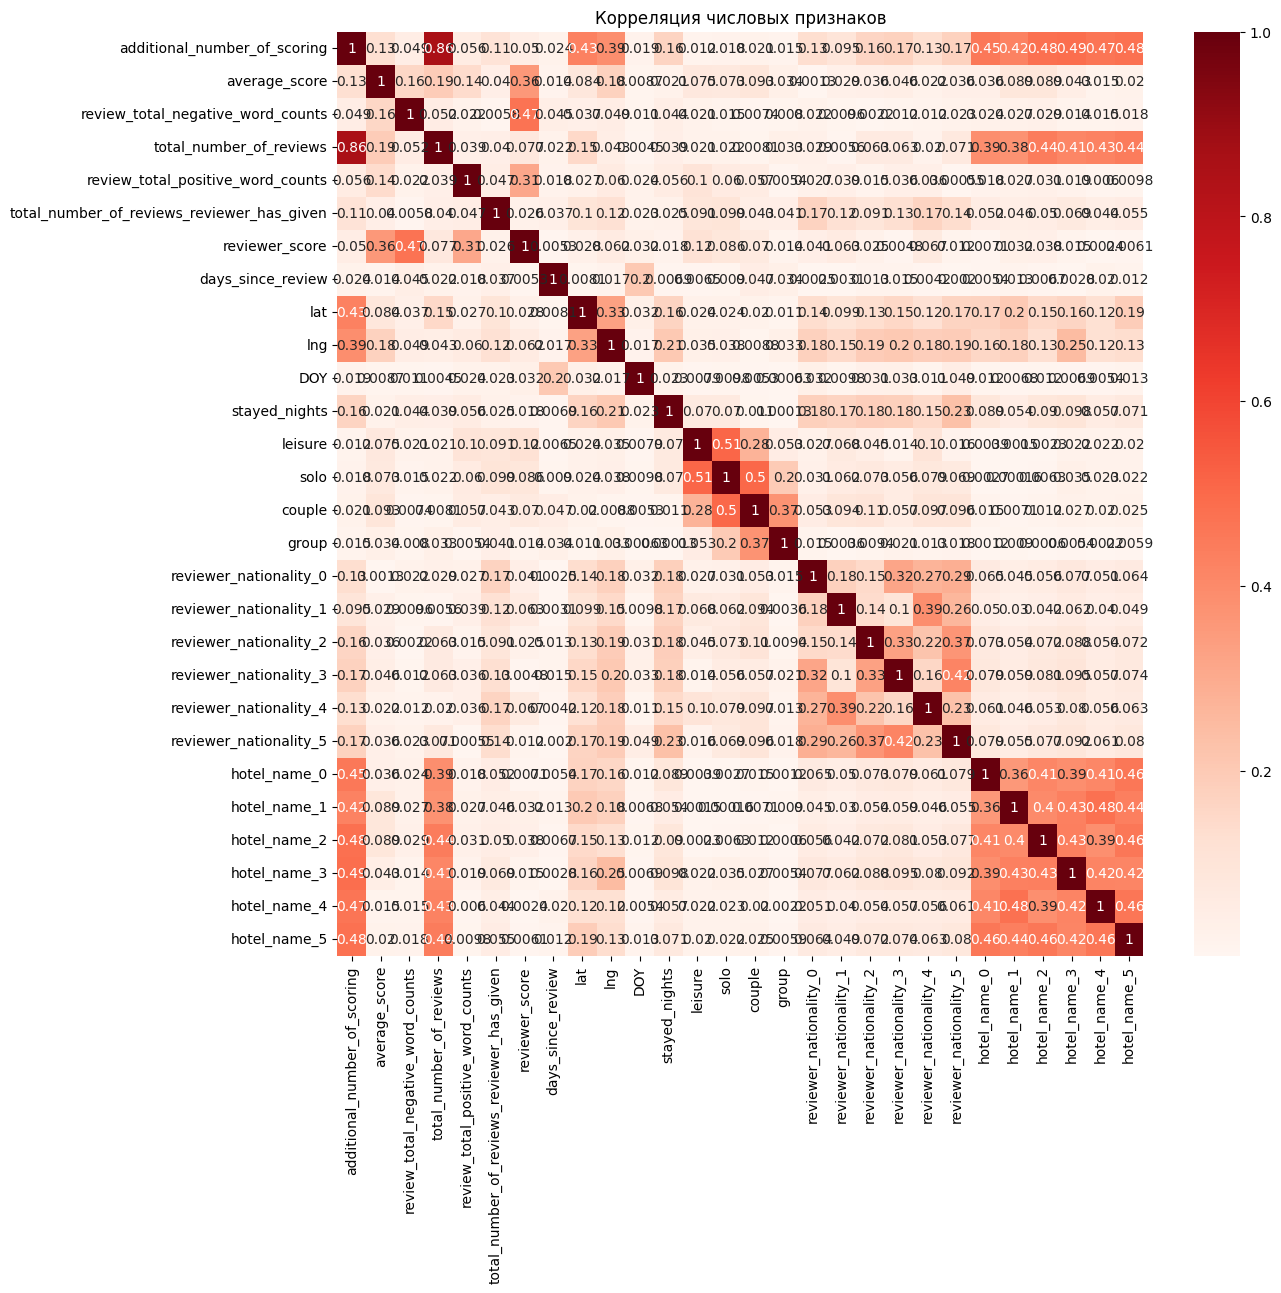

In [430]:
plt.figure(figsize=(13, 12))
heatmap = sns.heatmap(data=train_df.corr(method='spearman').abs(), annot=True, cmap='Reds')
heatmap.set_title('Корреляция числовых признаков')
plt.show()

In [431]:
drop_features_list = [
    'hotel_address',
    # 'additional_number_of_scoring',
    'review_date',
    # 'average_score',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    # 'review_total_negative_word_counts',
    # 'total_number_of_reviews',
    'positive_review',
    # 'review_total_positive_word_counts',
    # 'total_number_of_reviews_reviewer_has_given',
    # 'reviewer_score',
    'tags',
    # 'days_since_review',
    # 'city_Amsterdam',
    # 'city_Barcelona',
    # 'city_London',
    # 'city_Milan',
    # 'city_Paris',
    # 'city_Vienna',
    # 'lat',
    # 'lng'
]
for df_ in train_df, test_df:
    df_.drop(columns=drop_features_list, inplace=True)

## Обучение модели ##

In [432]:
X = train_df.drop(columns=['reviewer_score'])
y = train_df.reviewer_score
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE
                                                   )

In [433]:
regressor = RandomForestRegressor(
                                    n_estimators=100,
                                    n_jobs=4,
                                    random_state=RANDOM_STATE
                                 )
regressor.fit(X_train, y_train)
y_predictor = regressor.predict(X_test)

## Оценка качества модели ##

In [434]:
print(f'MAPE:', metrics.mean_absolute_percentage_error(y_test, y_predictor))

MAPE: 0.1358026435650925


## Оценка значимости признаков ##

In [435]:
display(pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False))

review_total_negative_word_counts             0.275243
review_total_positive_word_counts             0.155344
average_score                                 0.088297
days_since_review                             0.074610
DOY                                           0.073900
lat                                           0.048826
lng                                           0.048387
total_number_of_reviews                       0.042497
total_number_of_reviews_reviewer_has_given    0.041955
additional_number_of_scoring                  0.039920
stayed_nights                                 0.027335
couple                                        0.008509
leisure                                       0.008119
reviewer_nationality_3                        0.007194
reviewer_nationality_2                        0.007187
reviewer_nationality_5                        0.007079
solo                                          0.006907
reviewer_nationality_1                        0.006830
reviewer_n

## Формирование предсказаний ##

In [138]:
predictions = regressor.predict(test_df)
submission_df.reviewer_score = predictions
submission_df.head()

,reviewer_score,id
0,8.705,488440
1,7.294,274649
2,8.232,374688
3,9.551,404352
4,9.602,451596


In [139]:
submission_df.shape

(128935, 2)

In [140]:
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)